In [1]:
import torch
import time
import random
from matplotlib import pyplot as plt
import networkx as nx
from utils.clocks.global_clock import clock, GLOBAL_TIME, GLOBAL_WAVE, GLOBAL_PULSE, GLOBAL_SPIKE
from utils.neurons.LIFNeurons.leaky_integrate_and_fire import LIFNeuron, LIFNeuronGroup
from utils.sypanses.synapses import FeedForwardSynapses, Synapse

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())


def visualize_network(neurons, synapses):
    G = nx.DiGraph()

    for i in range(len(neurons)):
        G.add_node(f"N{i}")

    for syn in synapses:
        pre_idx = neurons.index(syn.pre)
        post_idx = neurons.index(syn.post)
        G.add_edge(f"N{pre_idx}", f"N{post_idx}", weight=syn.weight)

    pos = nx.spring_layout(G, seed=42)
    edge_labels = {(u, v): f"{d['weight']:.1f}" for u, v, d in G.edges(data=True)}

    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("Neuron Network Topology")
    plt.show()


def visualize_per_neuron_network(neuron_groups, synapse_layers):
    G = nx.DiGraph()
    group_prefix = ['I', 'H', 'O', 'X']  # add more if more groups
    group_nodes = []

    # Add neurons from each group
    for g_idx, group in enumerate(neuron_groups):
        prefix = group_prefix[g_idx]
        nodes = [f"{prefix}_{i}" for i in range(group.size)]
        G.add_nodes_from(nodes)
        group_nodes.append(nodes)

    # Add synapse connections per neuron
    for s_idx, syn in enumerate(synapse_layers):
        pre_nodes = group_nodes[s_idx]
        post_nodes = group_nodes[s_idx + 1]
        weights = syn.weights

        for post_idx, post_node in enumerate(post_nodes):
            for pre_idx, pre_node in enumerate(pre_nodes):
                w = weights[post_idx, pre_idx].item()
                if abs(w) > 1e-3:  # skip tiny weights for clarity
                    G.add_edge(pre_node, post_node, weight=w)

    # Layout with layers aligned left-to-right
    pos = {}
    x_spacing = 2.0
    y_spacing = 0.5
    for layer_idx, nodes in enumerate(group_nodes):
        for i, node in enumerate(nodes):
            pos[node] = (layer_idx * x_spacing, -i * y_spacing)

    edge_weights = nx.get_edge_attributes(G, 'weight')
    edge_labels = {e: f"{w:.1f}" for e, w in edge_weights.items()}

    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, node_size=300, node_color='lightblue', font_size=8, arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
    plt.title("Per-Neuron Spiking Network Topology")
    plt.axis('off')
    plt.tight_layout()
    plt.show()



def plot_neurons(timestamp, neuron_v, neuron_output):
    num_neurons = len(neuron_v)
    fig, axs = plt.subplots(num_neurons, 2, figsize=(12, num_neurons * 2), sharex=True)

    # Ensure axs is 2D even if there's only 1 neuron
    if num_neurons == 1:
        axs = axs.reshape(1, 2)

    for i in range(num_neurons):
        # Voltage subplot
        axs[i][0].plot(timestamp, neuron_v[i], label=f"V_neuron_{i}", color='tab:blue')
        axs[i][0].set_ylabel("Voltage")
        axs[i][0].set_title(f"Neuron {i} Voltage")
        axs[i][0].grid(True)

        # Spike subplot
        axs[i][1].plot(timestamp, neuron_output[i], label=f"Spikes_neuron_{i}", color='tab:red', drawstyle='steps-post')
        axs[i][1].set_ylabel("Spike")
        axs[i][1].set_yticks([0, 1])
        axs[i][1].set_title(f"Neuron {i} Spikes")
        axs[i][1].grid(True)

        if i == num_neurons - 1:
            axs[i][0].set_xlabel("Time (s)")
            axs[i][1].set_xlabel("Time (s)")

    plt.tight_layout()
    plt.show()

PyTorch version: 2.5.1
CUDA available: True
Number of GPUs: 1


In [2]:

def create_one_to_one_synapses(neurons, weight=1.0, random_weight=True):
    synapses = []
    for i in range(len(neurons) - 1):
        if random_weight:
            weight = random.uniform(10.0, 40.0)
        synapses.append(Synapse(pre_neuron=neurons[i], post_neuron=neurons[i+1], weight=weight))
    return synapses

def create_fully_connected_synapses(neurons, weight=1.0, random_weight=True):
    synapses = []
    for i, pre in enumerate(neurons):
        for j, post in enumerate(neurons):
            if random_weight:
                weight = random.uniform(10.0, 40.0)
            if i != j:  # avoid self-connections
                synapses.append(Synapse(pre_neuron=pre, post_neuron=post, weight=weight))
    return synapses

def create_ring_synapses(neurons, k=2, weight=1.0, random_weight=True):
    synapses = []
    N = len(neurons)
    for i in range(N):
        for j in range(1, k+1):
            if random_weight:
                weight = random.uniform(10.0, 40.0)
            pre = neurons[i]
            post_forward = neurons[(i + j) % N]
            post_backward = neurons[(i - j) % N]
            synapses.append(Synapse(pre, post_forward, weight))
            synapses.append(Synapse(pre, post_backward, weight))
    return synapses

def create_sparse_random_synapses(neurons, prob=0.1, weight=1.0, random_weight=True):
    synapses = []
    N = len(neurons)
    for i in range(N):
        for j in range(N):
            if i != j and random.random() < prob:
                if random_weight:
                    weight = random.uniform(10.0, 40.0)
                synapses.append(Synapse(neurons[i], neurons[j], weight))
    return synapses


In [6]:
neuron_params_input = dict(v_rest=0.0, v_thresh=0.5, v_reset=0.0, tau=15.0, r=1.0)
neuron_params_hidden = dict(v_rest=0.0, v_thresh=1.0, v_reset=0.0, tau=15.0, r=1.0)
neuron_params_output = dict(v_rest=0.0, v_thresh=1.0, v_reset=0.0, tau=50.0, r=1.0)


# --- Neuron groups ---
input_group = LIFNeuronGroup(size=784, **neuron_params_input, device=device)
hidden_group = LIFNeuronGroup(size=100, **neuron_params_hidden, device=device)
output_group = LIFNeuronGroup(size=10, **neuron_params_output, device=device)

# --- Layers ---
synapse_input_hidden = FeedForwardSynapses(pre=input_group, post=hidden_group, weight_scale=0.5)
synapse_hidden_output = FeedForwardSynapses(pre=hidden_group, post=output_group, weight_scale=0.2)

In [7]:
duration_ms = 1000
spike_rate = 0.50  # 5% chance of spiking

for t in range(duration_ms):
    # Generate random spike vector
    dummy_spikes = (torch.rand(input_group.size) < spike_rate).float()

    # Feed to input group
    input_group.receive_input(dummy_spikes.to(device=device))
    input_group.update()

    # Propagate to hidden
    synapse_input_hidden.propagate()
    hidden_group.update()

    # Propagate to output
    synapse_hidden_output.propagate()
    output_group.update()


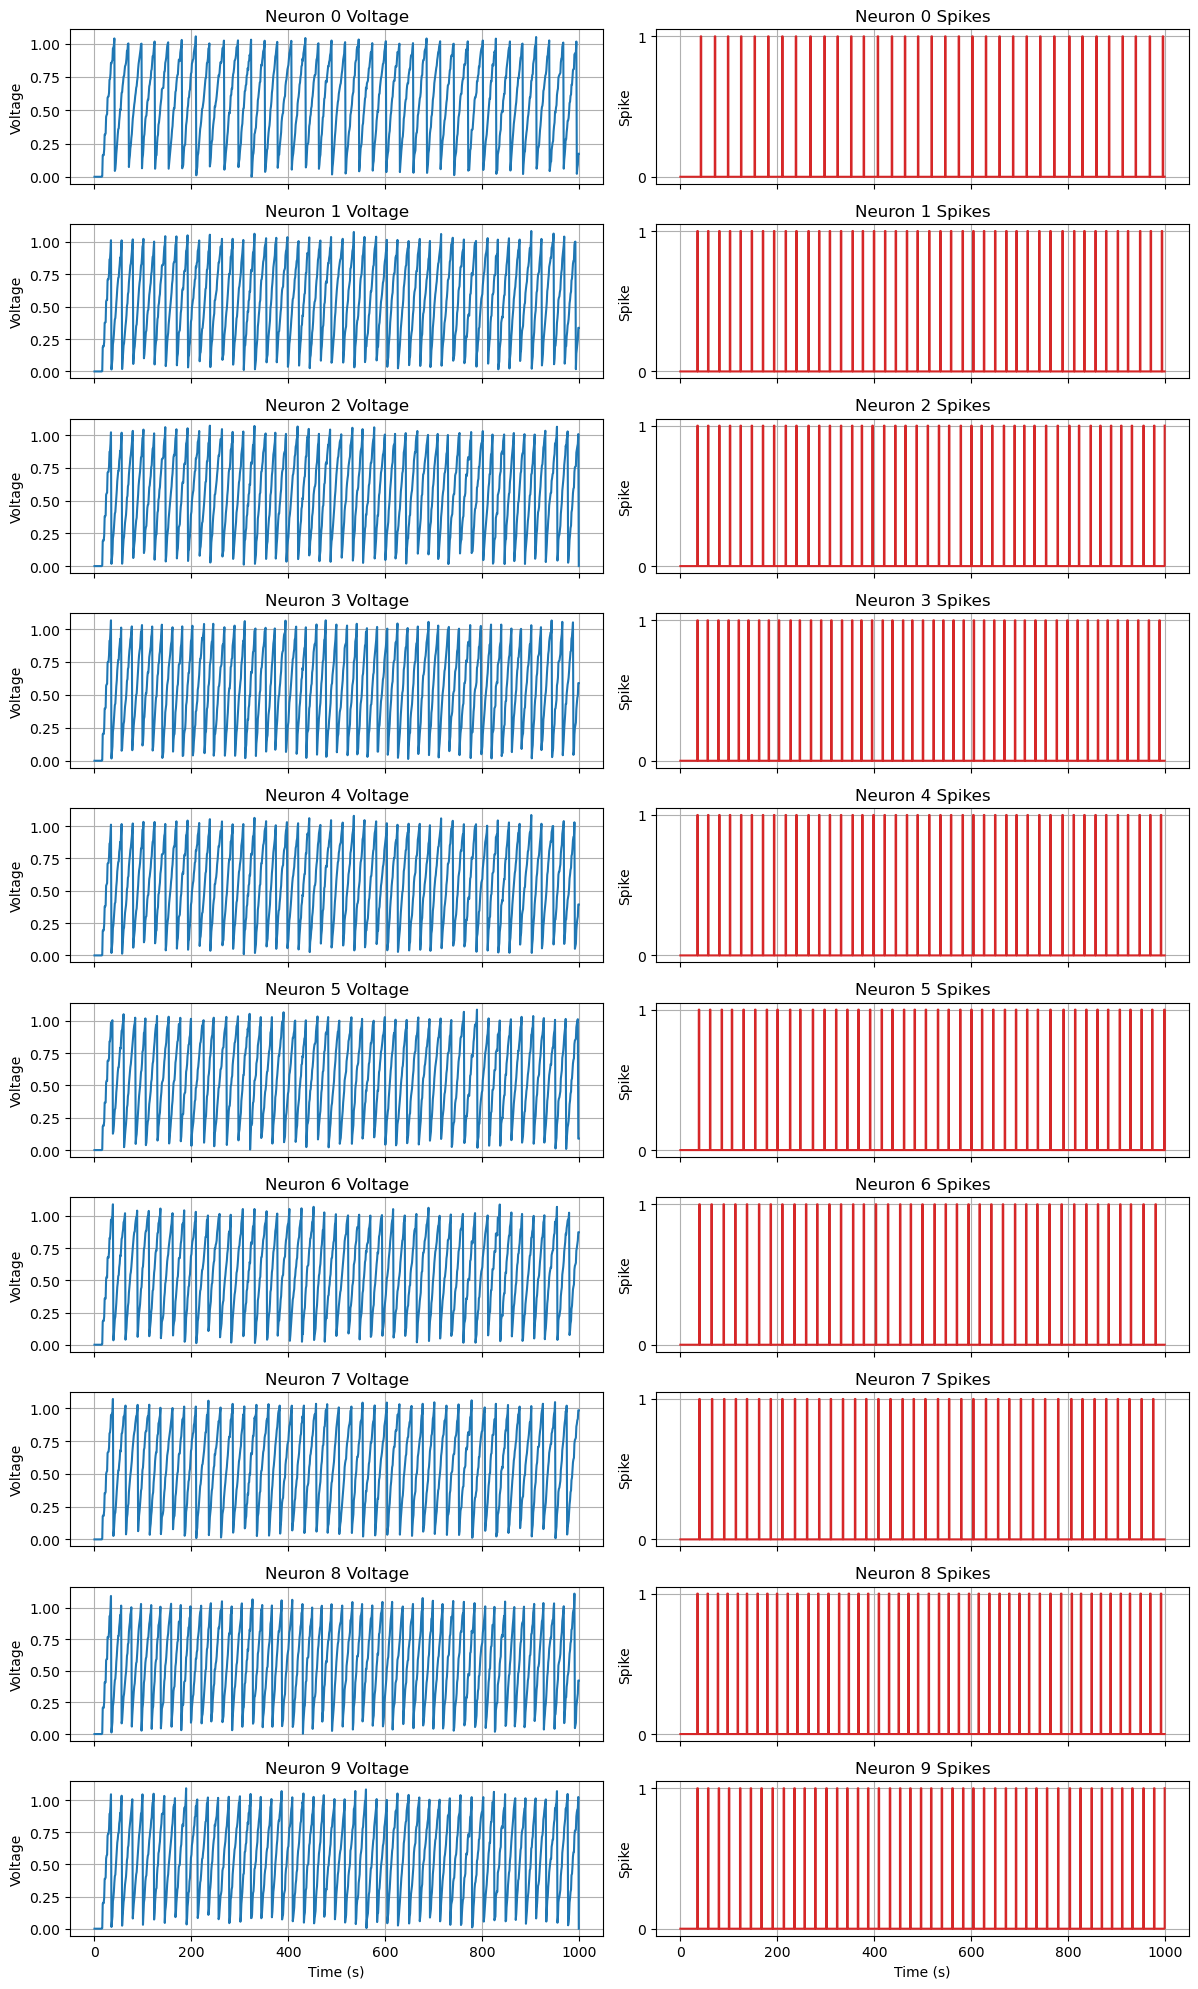

In [12]:
plot_neuron_group = output_group

v_trace = torch.stack(plot_neuron_group.v_trace).transpose(0, 1).cpu()
spike_trace = torch.stack(plot_neuron_group.spike_trace).transpose(0, 1).cpu()


timestamp = [i for i in range(1000)]
plot_neurons(timestamp, v_trace[0:10], spike_trace[0:10])

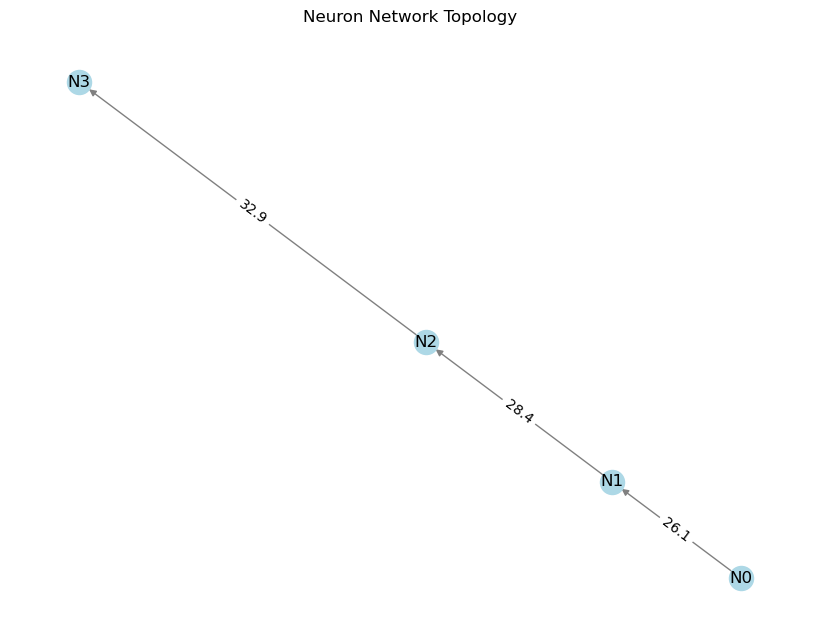

In [101]:
# Define the network
neurons = []

for i in range(4):
    if i == 0:
        neuron = LIFNeuron(
            v_rest=0.0, 
            v_thresh=1.0, 
            v_reset=0.0, 
            tau=15.0, 
            device=device)
    else:
        neuron = LIFNeuron(
            v_rest=0.0,
            v_thresh=random.uniform(0.8, 1.2),
            v_reset=0.0,
            tau=50.0,
            r=1.0,
            device=device
        )
    
    neurons.append(neuron)

synapses = create_one_to_one_synapses(neurons, weight=30.0)

visualize_network(neurons, synapses)

In [102]:
timer = clock(freq=2.0, sample_rate=100, amplitude=1.0)

update_rate = 1000
spike_train = []
timestamp = []
neuron_v = [[] for _ in neurons]
neuron_output = [[] for _ in neurons]

timer.start()
time.sleep(1)
try:
    while True:
        spike = GLOBAL_SPIKE.clone()
        timestamp.append(GLOBAL_TIME.item())
        spike_train.append(spike.item())
        
        I = torch.tensor([10.0], device=device)
        
        random_trigger = (torch.rand(1, device=device) > 0.2).to(torch.uint8)
        neurons[0].receive_input(I * spike * random_trigger)

        # Step 4: Update all neurons
        for neuron in neurons:
            neuron.update()

        # Step 5: Update all synapses
        for syn in synapses:
            syn.update()
        
        for i, neuron in enumerate(neurons):
            neuron_v[i].append(neuron.v.item())
            neuron_output[i].append(neuron.output.item())

        if GLOBAL_TIME.item() > 6:
            break
        
        time.sleep(1/update_rate)

except Exception as e:
    print(e)

finally:
    timer.stop()

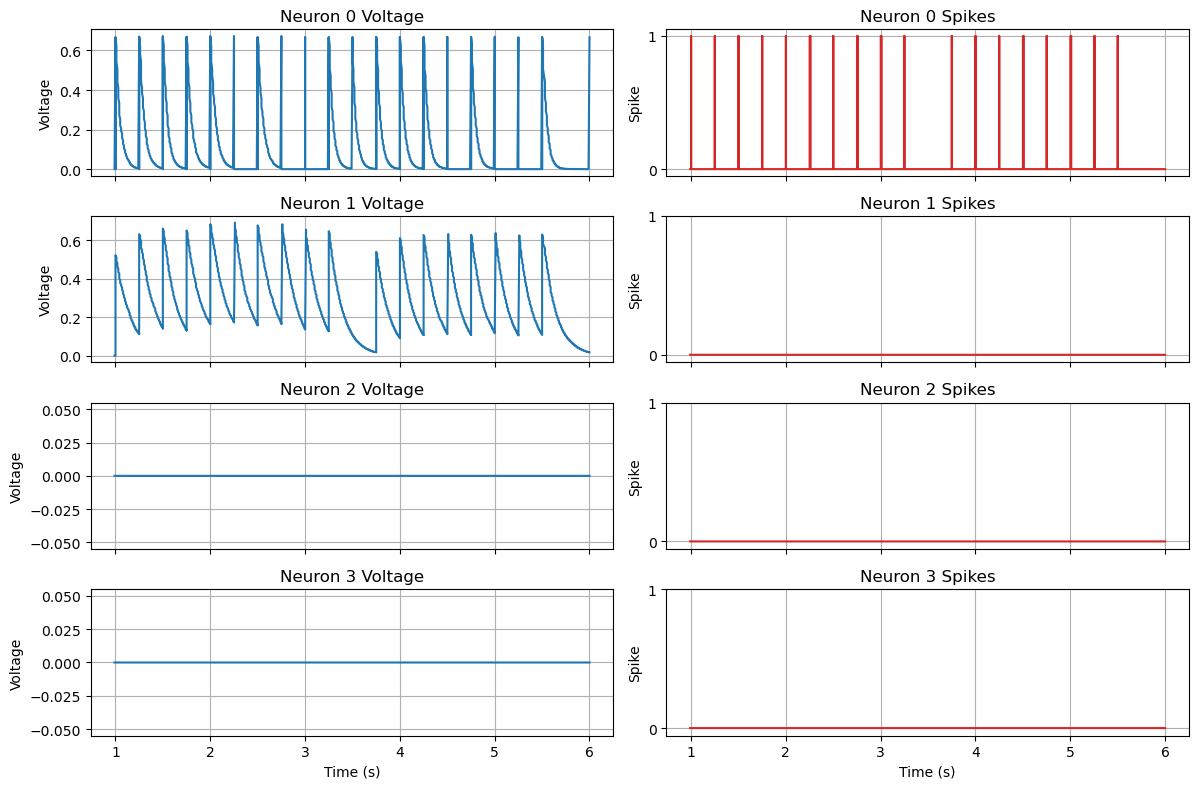

In [ ]:
plot_neurons(timestamp, neuron_v, neuron_output)